# Inlämningsuppgift: Del 2 - Adversarial input attack

Emil Karlström \
emkl19@student.bth.se

Samuel Jonsson \
sajs19@student.bth.se

# Instruktioner

Ändra notebookens platshållare så som era namn- och mailuppgifter samt instruktioner i de olika avsnitten. 

Notebookens underrubriker på nivå 3 (###) är bara ett enkelt exempel på hur er implementation kan delas upp. Ni bör skapa egna rubriker anpassade efter er implementation men lämna alla nivå 1 (#) och 2-rubriker (##) som de är. En viktig del inom data-science är att kunna presentera sina metoder och resultat på ett tydligt sätt. **En ostrukturerad och otydlig notebook kan påverka betygsättningen.**

Notera att t.ex. hyperparameter-tuning och annan optimisering för prestanda inte är nödvändigt i denna uppgift. Så länge modellen fungerar märkvärt bättre än ett "coin flip" så räcker det att ni väljer era hyperparametrar manuellt.

# Uppgiften

Uppgiften går ut på att göra så att bilden på koalan nedan klassificeras som en traktor istället. Givetvis ska bilden på koalan se helt oförändrad ut för det mänskliga ögat då attacken är genomförd. Nedan följer Pythonkod som läser in de båda bilderna som uppgiften bygger på samt läser in en ResNet50-modell som klassiciferar bilderna. Saknar ni några Python-paket, t.ex. TensorFlow så installera dem med en pakethanterarare, t.ex. pip

## Beskrivning av adversarial input attacker

Börja med att förklara vad denna typ av attacker är och hur de fungerar i rapportens sektion 2.1.

## Nedan följer kod för att läsa in bilderna och klassificera dem med ResNet50 modellen

In [1]:
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescentNumpy
from art.utils import to_categorical

tf.compat.v1.disable_eager_execution()

print(f"TensorFlow: {tf.__version__}")

2022-11-22 14:00:54.471111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 14:00:56.758440: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-22 14:00:56.759104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-22 14:00:56.759112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

TensorFlow: 2.11.0


In [2]:
# Loads the pretrained ResNet50 model
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


2022-11-22 14:01:02.829107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 14:01:02.877789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 14:01:02.878174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 14:01:06.991586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [3]:
# Load the two images (koala & tractor)
init_image = image.load_img("images/koala.jpeg", target_size=(224, 224))
init_image = image.img_to_array(init_image)

target_image = image.load_img("images/tractor.jpeg", target_size=(224, 224))
target_image = image.img_to_array(target_image)

class_lookup = {105: "koala", 866: "tractor"}

/home/emkl/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-11-22 14:01:12.831211: W tensorflow/c/c_api.cc:291] Operation '{name:'predictions/Softmax' id:3922 op device:{requested: '', assigned: ''} def:{{{node predictions/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](predictions/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2022-11-22 14:01:15.966932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2022-11-22 14:01:16.774982: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1

Init image class label: 105 (koala)


2022-11-22 14:01:17.058960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


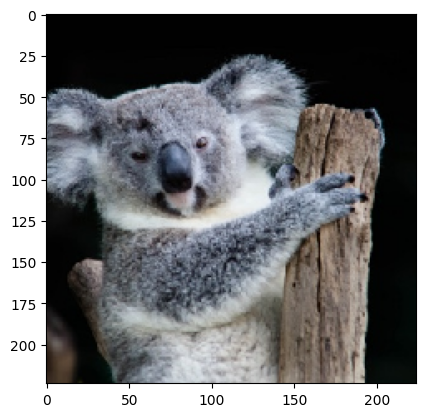

Target image class label: 866 (tractor)


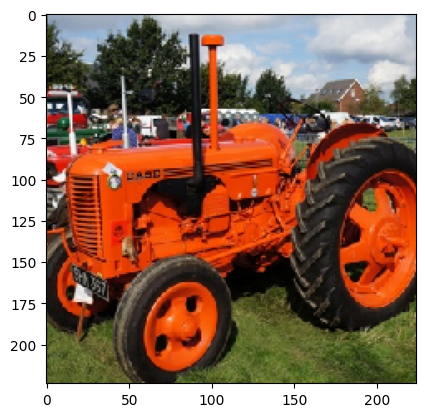

In [4]:
init_class_id = np.argmax(model.predict(np.array([init_image])))
print(f"Init image class label: {init_class_id} ({class_lookup[init_class_id]})")
plt.imshow(init_image.astype(np.uint))
plt.show()

target_class_id = np.argmax(model.predict(np.array([target_image])))
print(f"Target image class label: {target_class_id} ({class_lookup[target_class_id]})")
plt.imshow(target_image.astype(np.uint))
plt.show()

## Implementation av er attack

Beskriv i er rapport vad just er valda attack kallas och i detalj hur den fungerar (sektion 2.2 i rapporten). Beskriv även kort vilka bibliotek ni använder för att implementera den.

## Er kod för attacken

I cellerna nedan lägger ni in er egen kod för att genomföra attacken.

### Bibliotek

In [5]:
# Samla era import statements här e.g.
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# ...

from art.attacks.evasion import SignOPTAttack

### Egna funktioner

In [6]:
# Samla era egna funktioner relaterade till attacken här
# Funktionerna ska kort beskrivas med docstrings och kommentarer så att man förstår syftet och implementationen
# Blir det många bör ni bryta ut dessa i en separat fil

### Förberedelser

In [7]:
# E.g. inläsning av modell och dataset

keras_estimator = KerasClassifier(model, 
                            clip_values=(0,255))

pogboi = ProjectedGradientDescentNumpy(
    estimator=keras_estimator,
    targeted=True,
    eps=10,
    eps_step=0.5,
    max_iter=100,
    random_eps=True,
    batch_size=1024
)

### Modellering

In [8]:
# E.g. träning

x_adv = np.zeros((1, 224, 224, 3))

### Attack

Beskriv attackprocessen kortfattat här

In [9]:
# Attackutförande

target_id = 866 # Tractor ??

attack_image = init_image.reshape((1, 224, 224, 3))

attack_image = pogboi.generate(
    x = attack_image, 
    y = np.array(target_id).reshape((1,)),
    mask = np.array(1.).repeat(224*224*3).reshape((1,224,224,3))
    )
gen = attack_image

PGD - Random Initializations: 100%|██████████| 1/1 [00:20<00:00, 20.90s/it]


### Attackresultat

Summera och förklara era attackresultat i flytande text här

Generated image class label: 866 (tractor) (100.00%)


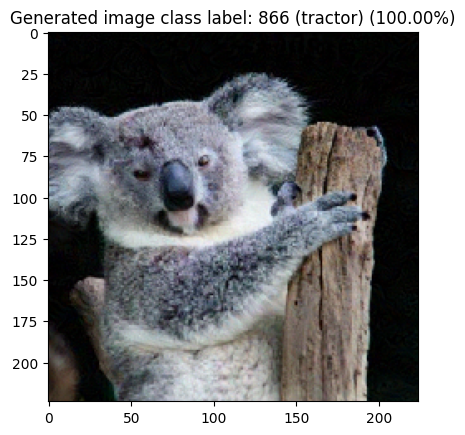

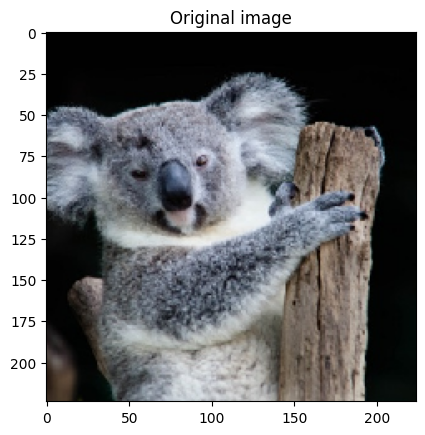

In [10]:
# Presentera attackens resultat m.h.a. kod här

preds = model.predict(gen)
gen_class_id = np.argmax(preds)
print(f"Generated image class label: {gen_class_id} ({class_lookup[gen_class_id]}) ({(100*preds[0][gen_class_id]):.2f}%)")
plt.imshow(gen.reshape((224, 224, 3)).astype(np.uint))
plt.title(f"Generated image class label: {gen_class_id} ({class_lookup[gen_class_id]}) ({(100*preds[0][gen_class_id]):.2f}%)")
plt.show()

plt.imshow(init_image.astype(int))
plt.title("Original image")
plt.show()


## Skyddsåtgärder

Beskriv (i rapportens sektion 2.3) vilka säkerhetsåtgärd(er) ni valt som lämpliga för att skydda mot er attack. Motivera varför ni valt just de(n) metod(erna).

## Implementation av skyddsåtgärder (frivilligt endast för A eller B)

Nedan fyller ni i er kod som implementerar skyddsmekanismen mot er attackmetod. Skriv även en summering av vad skyddsresultatet blev när ni implementerade metoden (beskriv detta i rapportens del 2.4).

### Egna funktioner

In [11]:
# Samla era egna funktioner relaterade till säkerhetsåtgärden här
# Funktionerna ska kort beskrivas med docstrings och kommentarer så att man förstår syftet och implementationen
# Blir det många bör ni bryta ut dessa i en separat fil

### Förberedelser

In [32]:
# E.g. skapande av ny modell, etc.
from art.defences.preprocessor import JpegCompression
jpeg_compressor = JpegCompression(clip_values=(0,255), quality=25)


### Skydd

Beskriv säkerhetsåtgärden kortfattat här

In [45]:
# Implementation av skyddsåtgärd
# https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/preprocessor.html#jpeg-compression

# Tanken är att vi använder oss av JPEG kompression för att sprida ut 
# de attackerade pixlarna över flera pixlar för att minska dess effekt
# på modellen :)
jpeg_gen = jpeg_compressor(gen)[0]
print(jpeg_gen)

(array([[[[ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         ...,
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.]],

        [[ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         ...,
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.]],

        [[ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         ...,
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.]],

        ...,

        [[62., 45., 35.],
         [61., 44., 34.],
         [60., 43., 33.],
         ...,
         [ 6., 15., 12.],
         [ 6., 15., 12.],
         [ 6., 15., 12.]],

        [[65., 48., 38.],
         [64., 47., 37.],
         [62., 45., 35.],
         ...,
         [ 6., 15., 12.],
         [ 6., 15., 12.],
         [ 6., 15., 12.]],

        [[67., 50., 40.],
         [65., 48., 38.],
         [63., 46., 36.],
         ...,
         [ 6., 15., 12.],
       

### Skyddsresultat

Bevisa och förklara era skyddsresultat i flytande text här

In [39]:
# Presentera skyddåtgärdens resultat m.h.a. kod här

# Predict the label
preds = model.predict(jpeg_gen)
gen_class_id = np.argmax(preds)

# Plot the 
plt.imshow(jpeg_gen.reshape((224, 224, 3)).astype(np.uint))
plt.title(f"JPEG Compressed label: {gen_class_id} ({class_lookup[gen_class_id]}) ({(100*preds[0][gen_class_id]):.2f}%)")
plt.show()

# Och det fungerar faktiskt ganska bra :^)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (2, 1)

# Referenser


1. Föreläsningar i kursen
2. https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd-numpy
3. https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/preprocessor.html#jpeg-compression